# Using citation redistribution to estimate unbiased expected citation count from a biased citation network

Author: Yuanxi Fu, Zhonghe Wan

Date: 2021-10-10

## Load packages

In [49]:
import pandas as pd
from igraph import * # install igraph in anaconda: https://anaconda.org/conda-forge/python-igraph
import cairo # install cairo and pychairo in anaconda: https://anaconda.org/anaconda/cairo; https://anaconda.org/anaconda/pycairo
import numpy as np
# import numpy.random as random
import math
from matplotlib import pyplot as plt
# from scipy.stats import bernoulli
# from statistics import stdev
# import scipy.stats

## Load data

We will use the following dataset of a biased ciation network:

de Vries, Ymkje Anna, & Munafò, M. (2016). [Dataset] Citation bias and selective focus on positive findings in the literature on 5-HTTLPR, life stress, and depression. University of Bristol. Retrieved January 28, 2021, http://doi.org/10.5523/BRIS.Z7JCONXFBMDR1JJ3T0W4K1HWN

In [2]:
# load the adjacency matrix
matrix = pd.read_csv('HTTLPR.csv')
matrix = matrix.iloc[:, 6:]

,Mossner,Caspi,Eley,Grabe_a,Kaufman_a,Gillespie,Kendler,Surtees,Sjoberg,Nakatani,...,Comasco_a,Cicchetti_b,Jenness,Scheid_b,Quinn,Grabe_b,Petersen,Beaver,Brown,Wilhelm_b
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-,X,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-,X,-,-,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,-,X,-,X,-,-,X,-,X,-,...,-,-,-,-,-,NaN,NaN,NaN,NaN,NaN
69,-,X,X,-,-,-,X,X,X,-,...,-,-,-,-,-,-,NaN,NaN,NaN,NaN
70,-,X,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,NaN,NaN,NaN
71,-,X,X,-,-,-,-,-,X,-,...,-,-,-,-,-,-,-,-,NaN,NaN


In [3]:
# load the attribute list
# easy for this file because the first 6 columns are in fact attribute list
attr_list = pd.read_csv('HTTLPR.csv', usecols=[0, 1, 2, 3, 4, 5])
attr_list['PaperID'] = attr_list.index

## Create a graph object g from the citation network data

In [4]:
# initialize the graph object
g = Graph(directed=True)
g.add_vertices(73)

# add attributes to the graph: study name: name; study outcome: outcome; YearOnline: year
# study = attr_list['Study'].to_list()
# outcome = attr_list['Outcome'].to_list()
g.vs['name'] = attr_list['Study']
g.vs["label"] = g.vs["name"]
g.vs['outcome'] = attr_list['Outcome']
g.vs['Year'] = attr_list['YearOnline']
g.vs['color'] = 'light blue'

# add edges from the adjacency matrix
edge_list = []
for i in range(0, matrix.shape[0]):
    for j in range(0, matrix.shape[1]):
        if isinstance(matrix.iloc[i, j], str):
            s = matrix.iloc[i, j]
            if s.replace(" ", "") == "X":
                edge_list.append((i, j))
                g.add_edge(source=i, target=j)

In [5]:
# total number of edges
len(g.es)

488

In [21]:
df_new = pd.DataFrame({'name': g.vs['name'], 'real_citation_count': g.degree(mode='in')})

,name,real_citation_count
0,Mossner,5
1,Caspi,65
2,Eley,37
3,Grabe_a,21
4,Kaufman_a,27
...,...,...
68,Grabe_b,0
69,Petersen,0
70,Beaver,0
71,Brown,0


## Create a "potential graph"

Create a "potential graph" (g_full) for the 5-HTTLPR in which all "potential citation paths" (Urlings et al., 2021) are connected . In our definition, a "potential citation path" exists between two publication if one paper is published one year or more earlier than another paper.

In [7]:
# potential graph
year_gap = 1

g_full = Graph(directed=True)
g_full.add_vertices(73)
g_full.vs['name'] = attr_list['Study']
g_full.vs["label"] = g_full.vs["name"]
g_full.vs['outcome'] = attr_list['Outcome']
g_full.vs['Year'] = attr_list['YearOnline']

full_edge_list=[]

for i in g_full.vs.indices:
    for j in g_full.vs.indices:
        if i>j and (g.vs[i]['Year']-g.vs[j]['Year']>=year_gap):
            full_edge_list.append((i,j))
            g_full.add_edge(source=i,target=j)

In [8]:
# number of edges in g_full
len(g_full.es)

2348

## Compute p(y)

Each paper in this dataset faces a pool of papers to choose from to cite ("potential references"). Under our definition, such a pool consists of papers published one year or more earlier than the citing paper. In the real world, the authors may be biased (i.e., they select a non-representative sample from the pool to cite). In this simulation, we will try to remove such a bias. We will compute p(y), number of performed citations divided by the total number of potential citations between papers published in year y and their pool of potential references. Using a Bernoulli random number generator, we will distribute the chance evenly among all potential references (i.e., each paper will enjoy an equal chance of p(y) to be cited).

In [9]:
generations = pd.unique(g.vs['Year'])
generations

array([2001, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012],
      dtype=int64)

In [10]:
performed_citation = [len(g.es.select(_source_in=g.vs.select(Year=year))) for year in generations]
performed_citation

[0, 0, 4, 13, 38, 81, 52, 81, 85, 91, 43]

In [11]:
potential_citation = [len(g_full.es.select(_source_in=g.vs.select(Year=year))) for year in generations]
potential_citation

[0, 1, 8, 24, 80, 198, 232, 407, 336, 660, 402]

### The first generation (2001) has no performed citation and no potential citation. Replace p(y) with NaN

In [12]:
p_y = [i/j for i, j in zip(performed_citation[1:], potential_citation[1:])]
p_y = [None] + p_y

[None,
 0.0,
 0.5,
 0.5416666666666666,
 0.475,
 0.4090909090909091,
 0.22413793103448276,
 0.19901719901719903,
 0.25297619047619047,
 0.13787878787878788,
 0.10696517412935323]

**NOTE**: p(y) first increases and then decreases over the years.

## Use p(y) to simulate unbiased networks

In [13]:
prob = pd.DataFrame({'year': generations,
                    'performed_citation': performed_citation,
                    'potential_citation': potential_citation,
                    'p(y)': p_y})

,year,performed_citation,potential_citation,p(y)
0,2001,0,0,NaN
1,2003,0,1,0.000000
2,2004,4,8,0.500000
3,2005,13,24,0.541667
4,2006,38,80,0.475000
5,2007,81,198,0.409091
6,2008,52,232,0.224138
7,2009,81,407,0.199017
8,2010,85,336,0.252976
9,2011,91,660,0.137879


In [14]:
pool = pd.DataFrame({'year': generations,'number of publications in each year':attr_list['YearOnline'].value_counts(sort=False),
                    'number of publications before the year':0})
pool['number of publications before the year']=pool['number of publications in each year'].cumsum()-pool['number of publications in each year']
pool.index = range(prob.shape[0])

,year,number of publications in each year,number of publications before the year
0,2001,1,0
1,2003,1,1
2,2004,4,2
3,2005,4,6
4,2006,8,10
5,2007,11,18
6,2008,8,29
7,2009,11,37
8,2010,7,48
9,2011,12,55


In [15]:
expected = prob['p(y)'] * pool['number of publications in each year']
expected = expected.to_frame('expected number of publications')
expected.drop(0)

,expected number of publications
1,0.000000
2,2.000000
3,2.166667
4,3.800000
5,4.500000
6,1.793103
7,2.189189
8,1.770833
9,1.654545
10,0.641791


In [16]:
expected_indegree = expected[::-1]['expected number of publications'].cumsum().to_list()
expected_indegree = expected_indegree[::-1]
expected_indegree = expected_indegree[1:]

[20.516129136786628,
 20.516129136786628,
 18.516129136786628,
 16.34946247011996,
 12.549462470119959,
 8.049462470119959,
 6.256359021844097,
 4.0671698326549075,
 2.296336499321574,
 0.6417910447761194]

In [31]:
a = []
for i in range(expected.shape[0]-1):
    a.extend([expected_indegree[i]]*int(pool.iloc[i,]['number of publications in each year']))

a.extend([0]*pool.iloc[-1,1]) # extend the last generations, expected citations were zero

[20.516129136786628,
 20.516129136786628,
 18.516129136786628,
 18.516129136786628,
 18.516129136786628,
 18.516129136786628,
 16.34946247011996,
 16.34946247011996,
 16.34946247011996,
 16.34946247011996,
 12.549462470119959,
 12.549462470119959,
 12.549462470119959,
 12.549462470119959,
 12.549462470119959,
 12.549462470119959,
 12.549462470119959,
 12.549462470119959,
 8.049462470119959,
 8.049462470119959,
 8.049462470119959,
 8.049462470119959,
 8.049462470119959,
 8.049462470119959,
 8.049462470119959,
 8.049462470119959,
 8.049462470119959,
 8.049462470119959,
 8.049462470119959,
 6.256359021844097,
 6.256359021844097,
 6.256359021844097,
 6.256359021844097,
 6.256359021844097,
 6.256359021844097,
 6.256359021844097,
 6.256359021844097,
 4.0671698326549075,
 4.0671698326549075,
 4.0671698326549075,
 4.0671698326549075,
 4.0671698326549075,
 4.0671698326549075,
 4.0671698326549075,
 4.0671698326549075,
 4.0671698326549075,
 4.0671698326549075,
 4.0671698326549075,
 2.296336499321

In [22]:
df_new['expected_citation_count'] = [round(elem,3) for elem in a]

,name,real_citation_count,expected_citation_count
0,Mossner,5,20.516
1,Caspi,65,20.516
2,Eley,37,18.516
3,Grabe_a,21,18.516
4,Kaufman_a,27,18.516
...,...,...,...
68,Grabe_b,0,0.000
69,Petersen,0,0.000
70,Beaver,0,0.000
71,Brown,0,0.000


In [55]:
df_new.loc[df_new['expected_citation_count'] != 0,'ratio'] = df_new.loc[df_new['expected_citation_count'] != 0,'real_citation_count']/df_new.loc[df_new['expected_citation_count'] != 0,'expected_citation_count']
df_new['ratio'] = round(df_new['ratio'],3)

,name,real_citation_count,expected_citation_count,ratio
0,Mossner,5,20.516,0.244
1,Caspi,65,20.516,3.168
2,Eley,37,18.516,1.998
3,Grabe_a,21,18.516,1.134
4,Kaufman_a,27,18.516,1.458
...,...,...,...,...
68,Grabe_b,0,0.000,NaN
69,Petersen,0,0.000,NaN
70,Beaver,0,0.000,NaN
71,Brown,0,0.000,NaN


In [26]:
ratio_max = df_new['ratio'].max()

In [47]:
if ratio_max - math.floor(ratio_max)>0.5:
    x_max = math.floor(ratio_max)+1
else:
    x_max = math.floor(ratio_max) + 0.5

bins = list(np.arange(0,(x_max+0.5),0.5))

[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]

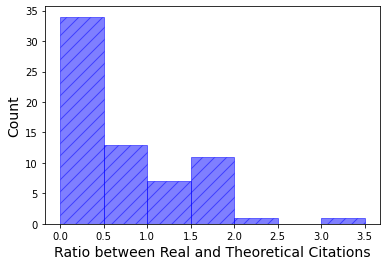

In [51]:
plt.hist(df_new['ratio'], bins=bins,color='blue', edgecolor='blue', linewidth=1, hatch="//",
         histtype='bar', alpha=0.5)
plt.xlabel('Ratio between Real and Theoretical Citations',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.show()

## Bottom 10 "marginalized papers" with non-zero ratio between real and expected citations

In [56]:
df_new.loc[df_new['ratio'] !=0].sort_values(by='ratio').head(10)

,name,real_citation_count,expected_citation_count,ratio
18,Dick,1,8.049,0.124
19,Kraus,1,8.049,0.124
32,Lotrich,1,6.256,0.160
0,Mossner,5,20.516,0.244
40,Kim_b,1,4.067,0.246
46,Coventry,1,4.067,0.246
45,Gibb,1,4.067,0.246
28,Kilpatrick,2,8.049,0.248
35,PhillipsBute,2,6.256,0.320
29,Bull,2,6.256,0.320


## Old method (Fu, Yuan, and Schneider, 2021)